In [3]:
from dataclasses import dataclass

import numpy as np
import rosparam
import rospy


# math and robotics
import numpy as np
import spatialmath as sm
import quaternion
from tqdm.notebook import tqdm, trange

# plotting 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt

# simulated robot content and helpers
import hrr_common as hrr_cm
import hrr_cobot_robot as hrr_rob

# ROS
import rospy

# set printing and plotting options    
np.set_printoptions(precision=5, suppress=True)
sns.set_theme('notebook')
%matplotlib notebook

In [4]:
hrr_common.utils.set_ros_environment(ros_master = 'hrrcobotLinux54')

NameError: name 'hrr_common' is not defined

In [5]:
rospy.init_node('restore_old_behavior')

In [7]:
cobot = hrr_rob.HrrCobotControl.from_ros(cobot_prefix="/hrr_cobot/")
rospy.sleep(0.1)
cobot.update()
print(cobot)

Hrr-Cobot state:
FT-data:
current force:	[  5.40424   0.33203 -30.86426] [N]
current torque:	[-1.01385 -9.19135  0.75537] [Nm]
current wrench:	[ 1.0264   0.63191  0.68431 -0.4011   1.07986  0.30058] [N,Nm]
=>in contact:	False
---
Robot-data:
q:		[ -0.06832  -0.01282 -90.01441   0.37233  89.93997   0.10318][°]
q_dot:		[0. 0. 0. 0. 0. 0.][rad/s]
tau:		[0. 0. 0. 0. 0. 0.][Nm]
pos:		[ 0.43594 -0.       0.70499][m]
quat:		0.00051 <[-0.0015   0.99999 -0.00326]>
tool-pos:	[ 0.43594 -0.       0.70499][m]
tool-rpy:	[179.82849   0.05904 179.62671][°]
robot-status:	moving
---
tool set to shaft_grinder

---


## Calibrate

In [5]:
if -np.pi/4.0 < cobot.q[0]  < np.pi/4.0:
    q_calib = cobot.q_calib
elif np.pi/4.0 < cobot.q[0]  < 3.0 *np.pi/4.0:
    q_calib = np.r_[np.pi/2.0, cobot.q_calib[1:]]
elif -3.0 * np.pi /4.0 < cobot.q[0]  < -np.pi/4.0:
    q_calib = np.r_[-np.pi/2.0, cobot.q_calib[1:]]
else:
    print('fuck off')
print(q_calib)

[-1.5708  0.     -1.5708  0.      1.5708  0.    ]


In [7]:
cobot.goTo(cobot.FK(cobot.q_calib),v_max=0.05)

[INFO]reached desired goal-pose:
  -1         0         0         0.4359    
   0         1         0         0         
   0         0        -1         0.705     
   0         0         0         1         



In [8]:
data = cobot.collect_calibration_data(gains=(0.5, 0.5, 1.0), v=0.2, N=250, force=True)

<IPython.core.display.Javascript object>


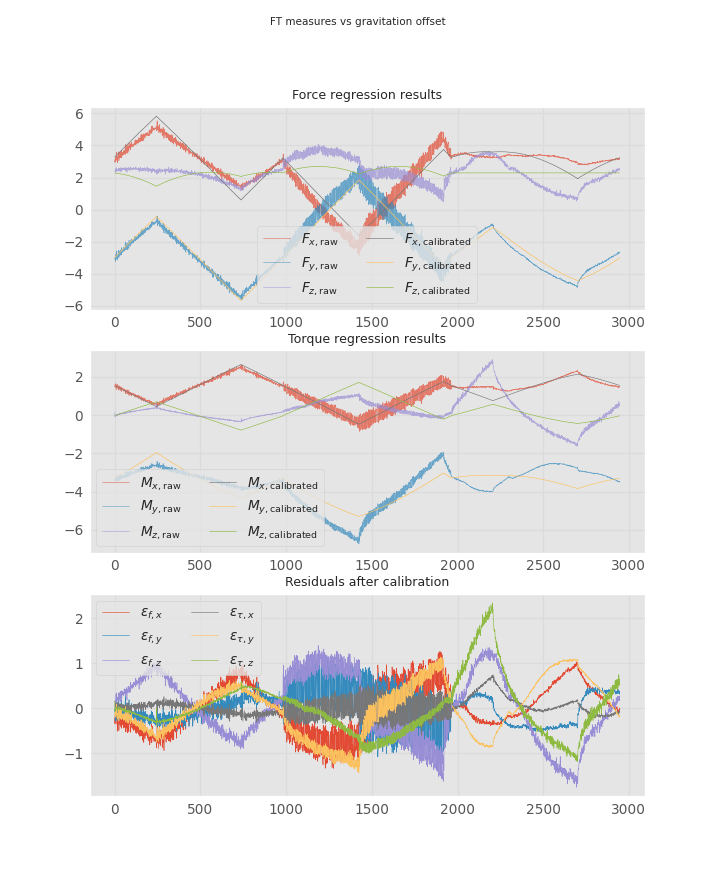

In [9]:
cobot._ft_handle.set_offset(*hrr_rob.ros_interfaces.freespace_offset_regression(data, cobot.R_FT_E, plot=True, call_plot=True))

In [11]:
cobot.update()
cobot.B_F_msr

array([-0.24248, -0.14653,  0.12635, -0.21913,  0.14532, -0.05489])

## Enable compliance

In [16]:
cobot._sns_vel_compliance(np.r_[np.ones(3), np.zeros(3)], K_t=8e-4, K_f=5e-4) # pos only

In [ ]:
cobot._sns_vel_compliance(np.ones(6), K_t=8e-4, K_f=5e-4) # full

In [17]:
while True:
    cobot.update()
cobot.stop()

KeyboardInterrupt: 

In [ ]:
# IGNORE REST BELOW

In [20]:
test = ScrewdriverPins()
test.sanity_check()

{10: True, 7: False, 8: False, 9: True}

[pin: 10
 state: True,
 pin: 7
 state: False,
 pin: 8
 state: True,
 pin: 9
 state: True]

In [23]:
cobot.close_tool_changer()

In [24]:
cobot.change_tool("screwdriver")

True

In [50]:
cobot.tool_controller.screwdriver_program = 1

In [47]:
cobot.tool_controller._send_sc_prog()

In [26]:
self = cobot.tool_controller
pin_srv = self._get_pin_srv()
for req in self._screwdriver_pins.program_to_ros_msg(self.screwdriver_program):
    pin_srv(req)

In [19]:
cobot.tool_controller._screwdriver_pins.program_to_ros_msg(cobot.tool_controller.screwdriver_program)

[pin: 10
 state: True,
 pin: 7
 state: False,
 pin: 8
 state: True,
 pin: 9
 state: False]

In [12]:
from comau_msgs.srv import GetComauParams, GetComauParamsRequest
robot_status = rospy.ServiceProxy('/hrr_cobot/get_comau_parameters', GetComauParams)

In [41]:
test.set_program(8), robot_status(GetComauParamsRequest()).digital_out_states[3:7]

({10: True, 7: True, 8: True, 9: True},
 [pin: 7
  state: True,
  pin: 8
  state: False,
  pin: 9
  state: False,
  pin: 10
  state: True])

In [43]:
test.set_program(5)

{10: True, 7: True, 8: False, 9: False}

In [51]:
robot_status(GetComauParamsRequest()).digital_out_states[3:7]

[pin: 7
 state: False,
 pin: 8
 state: False,
 pin: 9
 state: False,
 pin: 10
 state: True]